## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

In [2]:
pd.set_option('display.max_columns', 200)

## Loading the data

In [3]:
# Opening JSON file 
f = open("E:\Documents\AIML_masters\course5_NLP\week6\complaints-2021-05-14_08_16.json", 'r')  
  
# returns JSON object as a dictionary 
data = json.load(f)
df=pd.json_normalize(data)


## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [5]:
df.shape

(78313, 22)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [7]:
# print the column names

df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [8]:
new_columns = [column.replace('_source.', '') if column.find('_source.')!=-1 else column.replace('_', '') for column in df.columns]
print(new_columns)

['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id', 'issue', 'date_received', 'state', 'consumer_disputed', 'product', 'company_response', 'company', 'submitted_via', 'date_sent_to_company', 'company_public_response', 'sub_product', 'timely', 'complaint_what_happened', 'sub_issue', 'consumer_consent_provided']


In [9]:
# Assign new column names

df.columns = new_columns

In [10]:
df.head()


,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [11]:
# check whether null values exist from 'complaint_what_happened'

df['complaint_what_happened'].isnull().sum()

0

In [12]:
# get rows with 'complaint_what_happened' with empty values ''

df[df['complaint_what_happened'] == ''].head()


,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A


In [13]:
# total complaints with empty values

df[df['complaint_what_happened'] == ''].shape

(57241, 22)

In [14]:
# Remove all rows where complaints column is nan

df_final = df[df['complaint_what_happened'] != ''].copy()
df_final.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


In [15]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      21072 non-null  object 
 1   type                       21072 non-null  object 
 2   id                         21072 non-null  object 
 3   score                      21072 non-null  float64
 4   tags                       3816 non-null   object 
 5   zip_code                   16427 non-null  object 
 6   complaint_id               21072 non-null  object 
 7   issue                      21072 non-null  object 
 8   date_received              21072 non-null  object 
 9   state                      20929 non-null  object 
 10  consumer_disputed          21072 non-null  object 
 11  product                    21072 non-null  object 
 12  company_response           21072 non-null  object 
 13  company                    21072 non-null  obj

## Preparing The Text

In [16]:
# removing all the unnecessary elements using regular expressions

def text_preprocessing(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub(f'[{string.punctuation}]', '', text)
    text = re.sub(r'\w*\d+\w*', '', text)
    return text

In [17]:
# Lemmatizing the texts

wnl = nltk.stem.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')

def lemmatize_text(text):
    tokens = nltk.tokenize.word_tokenize(text)
    lemmatized_tokens = [wnl.lemmatize(token) for token in tokens if token not in stopwords]
    return ' '.join(lemmatized_tokens)

In [18]:
# Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 

df_clean = df_final.reset_index(drop=True).copy()
df_clean['preprocessed_complaints'] = df_clean['complaint_what_happened'].apply(text_preprocessing)
df_clean['lemmatized_complaints'] = df_clean['preprocessed_complaints'].apply(lemmatize_text)

In [19]:
df_clean.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,preprocessed_complaints,lemmatized_complaints
0,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...
1,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...
2,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...
3,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...
4,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...


In [20]:
# Write your function to extract the POS tags 
nlp = spacy.load("en_core_web_sm")
nlp.disable_pipe('ner')
nlp.disable_pipe('lemmatizer')

def pos_tag(text):
    doc = nlp(text)
    tokens = [token.text for token in doc if token.tag_=='NN']
    return ' '.join(tokens)

In [21]:
df_clean["complaint_POS_removed"] = df_clean['lemmatized_complaints'].apply(pos_tag)

In [22]:
df_clean.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,preprocessed_complaints,lemmatized_complaints,complaint_POS_removed
0,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name chase debt verification statement...
1,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,card agent upgrade anniversary date agent info...
2,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,card application identity consent service cred...
3,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,book ticket offer ticket reward card informati...
4,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son check deposit chase account fund account m...


## Exploratory data analysis to get familiar with the data.

In [23]:
# visualising the data according to the 'Complaint' character length

df_clean['before_clean_length'] = df_clean['complaint_what_happened'].apply(len)
df_clean['after_clean_length'] = df_clean['complaint_POS_removed'].apply(len)

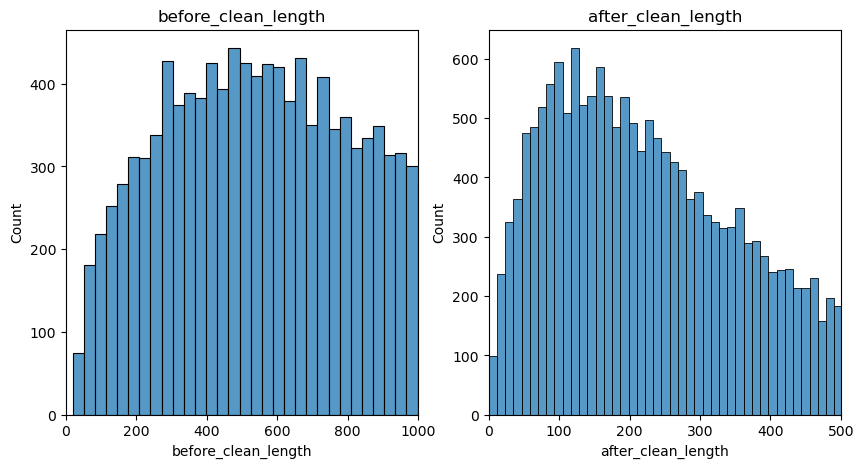

In [24]:
# plotting most complaints length

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax1.set_title('before_clean_length')
ax1.set_xlim((0, 1000))
sns.histplot(data=df_clean, x='before_clean_length', bins=1000)
ax2 = fig.add_subplot(122)
ax2.set_title('after_clean_length')
ax2.set_xlim((0, 500))
sns.histplot(data=df_clean, x='after_clean_length', bins=1000)
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

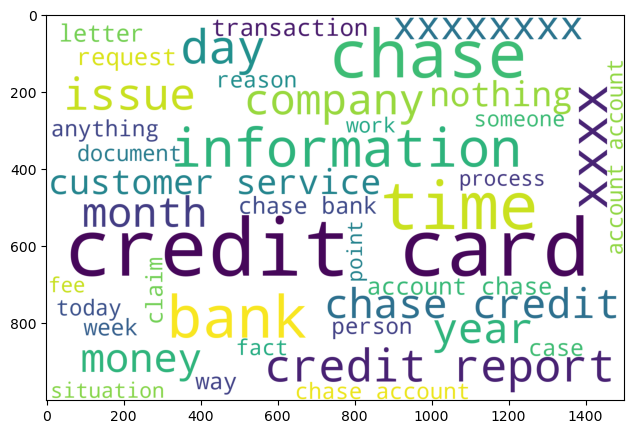

In [25]:
# Using a word cloud to find the top 40 words by frequency among all the articles after processing the text

from wordcloud import WordCloud
plt.figure(figsize=(8, 5))
complaint_text = ' '.join(df_clean['complaint_POS_removed'].tolist())
wc = WordCloud(width=1500, height=1000, max_words=40, background_color='white').generate(complaint_text)
plt.imshow(wc)

In [26]:
# Removing -PRON- from the text corpus

df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [27]:
# Removing personal details of the customers

df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [28]:
df_clean.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,preprocessed_complaints,lemmatized_complaints,complaint_POS_removed,before_clean_length,after_clean_length,Complaint_clean
0,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name chase debt verification statement...,486,129,morning name chase debt verification statement...
1,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,card agent upgrade anniversary date agent info...,355,108,card agent upgrade anniversary date agent info...
2,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,card application identity consent service cred...,224,67,card application identity consent service cred...
3,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,book ticket offer ticket reward card informati...,1502,376,book ticket offer ticket reward card informati...
4,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son check deposit chase account fund account m...,477,161,son check deposit chase account fund account m...


#### Finding the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [29]:
# finding the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 

corpus = df_clean['Complaint_clean']
vec = CountVectorizer(ngram_range=(1, 1))
unigram_vec = vec.fit_transform(corpus)
total_count_vec = unigram_vec.sum(axis=0)
unigram_freq = [(word, total_count_vec[0, idx]) for word, idx in vec.vocabulary_.items()]
unigram_sorted = sorted(unigram_freq, key=lambda x: x[1], reverse=True)
top_30_unigram = unigram_sorted[:30]
top_30_unigram

[('chase', 54018),
 ('account', 42419),
 ('credit', 32549),
 ('card', 29895),
 ('payment', 21112),
 ('bank', 17973),
 ('time', 15939),
 ('day', 12867),
 ('charge', 11937),
 ('money', 11858),
 ('loan', 10483),
 ('information', 9543),
 ('check', 9540),
 ('letter', 9322),
 ('fee', 8858),
 ('number', 8592),
 ('call', 8576),
 ('month', 8448),
 ('year', 8233),
 ('amount', 8214),
 ('customer', 8036),
 ('transaction', 7934),
 ('mortgage', 7706),
 ('report', 7653),
 ('balance', 7571),
 ('phone', 7394),
 ('service', 7311),
 ('company', 7087),
 ('fund', 6757),
 ('claim', 6685)]

In [30]:
# Printing the top 10 words in the unigram frequency

top_10_unigram = unigram_sorted[:10]
top_10_unigram_words = [pair[0] for pair in top_10_unigram]
top_10_unigram_words

['chase',
 'account',
 'credit',
 'card',
 'payment',
 'bank',
 'time',
 'day',
 'charge',
 'money']

In [31]:
# finding the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean)

corpus = df_clean['Complaint_clean']
bi_vec = CountVectorizer(ngram_range=(2, 2))
bigram_vec = bi_vec.fit_transform(corpus)
total_count_bivec = bigram_vec.sum(axis=0)
bigram_freq = [(word, total_count_bivec[0, idx]) for word, idx in bi_vec.vocabulary_.items()]
bigram_sorted = sorted(bigram_freq, key=lambda x: x[1], reverse=True)
top_30_bigram = bigram_sorted[:30]
top_30_bigram

[('credit card', 12762),
 ('credit report', 3811),
 ('chase credit', 3316),
 ('customer service', 2928),
 ('account chase', 2777),
 ('chase bank', 2588),
 ('chase account', 2402),
 ('account account', 2309),
 ('debit card', 1922),
 ('card chase', 1820),
 ('bank account', 1819),
 ('card account', 1765),
 ('credit score', 1703),
 ('phone call', 1665),
 ('chase card', 1641),
 ('payment payment', 1575),
 ('account credit', 1441),
 ('money account', 1417),
 ('letter chase', 1307),
 ('payment chase', 1299),
 ('interest rate', 1284),
 ('phone number', 1242),
 ('business day', 1203),
 ('checking account', 1158),
 ('account number', 1140),
 ('card company', 1116),
 ('call chase', 1113),
 ('card card', 1108),
 ('chase chase', 1100),
 ('card credit', 1072)]

In [32]:
# Printing the top 10 words in the bigram frequency

top_10_bigram = bigram_sorted[:10]
top_10_bigram_words = [pair[0] for pair in top_10_bigram]
top_10_bigram_words

['credit card',
 'credit report',
 'chase credit',
 'customer service',
 'account chase',
 'chase bank',
 'chase account',
 'account account',
 'debit card',
 'card chase']

In [33]:
# finding the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 

corpus = df_clean['Complaint_clean']
tri_vec = CountVectorizer(ngram_range=(3, 3))
trigram_vec = tri_vec.fit_transform(corpus)
total_count_trivec = trigram_vec.sum(axis=0)
trigram_freq = [(word, total_count_trivec[0, idx]) for word, idx in tri_vec.vocabulary_.items()]
trigram_sorted = sorted(trigram_freq, key=lambda x: x[1], reverse=True)
top_30_trigram = trigram_sorted[:30]
top_30_trigram

[('chase credit card', 2322),
 ('credit card account', 1136),
 ('credit card company', 981),
 ('credit card chase', 847),
 ('credit card credit', 531),
 ('inquiry credit report', 519),
 ('card credit card', 428),
 ('chase customer service', 415),
 ('account credit card', 414),
 ('credit reporting agency', 373),
 ('charge credit card', 367),
 ('credit report credit', 352),
 ('credit card payment', 319),
 ('chase checking account', 301),
 ('account credit report', 299),
 ('customer service representative', 288),
 ('chase auto finance', 272),
 ('bank credit card', 268),
 ('credit card balance', 267),
 ('phone call chase', 265),
 ('credit card card', 251),
 ('chase card service', 251),
 ('account chase account', 243),
 ('credit report chase', 237),
 ('payment credit card', 234),
 ('credit card charge', 234),
 ('freedom credit card', 234),
 ('credit card statement', 230),
 ('credit card bank', 229),
 ('credit card service', 226)]

In [34]:
# Printing the top 10 words in the trigram frequency

top_10_trigram = trigram_sorted[:10]
top_10_trigram_words = [pair[0] for pair in top_10_trigram]
top_10_trigram_words

['chase credit card',
 'credit card account',
 'credit card company',
 'credit card chase',
 'credit card credit',
 'inquiry credit report',
 'card credit card',
 'chase customer service',
 'account credit card',
 'credit reporting agency']

## Feature Extraction

In [35]:
# Initialising the TfidfVectorizer 

tfidf_vectorizer = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

#### Creating a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [36]:
# creating the Document Term Matrix by transforming the complaints column present in df_clean.

tfidf_vectors  = tfidf_vectorizer.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In [37]:
from sklearn.decomposition import NMF

In [38]:
# Loading your nmf_model with the n_components i.e 5
num_topics = 5 

# keeping the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [39]:
# fitting the model

nmf_model.fit(tfidf_vectors)
len(tfidf_vectorizer.get_feature_names_out())

C:\Users\Leander Antony A\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



6236

In [40]:
# Printing the Top15 words for each of the topics

for idx, topic in enumerate(nmf_model.components_):
    print(f'Topic {idx} - Top 15 words are:')
    words = [tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-15:]]
    print(words)
    print('='*30)

Topic 0 - Top 15 words are:
['customer', 'business', 'fee', 'claim', 'number', 'transaction', 'branch', 'day', 'deposit', 'fund', 'chase', 'bank', 'money', 'check', 'account']
Topic 1 - Top 15 words are:
['customer', 'company', 'time', 'merchant', 'fee', 'balance', 'fraud', 'transaction', 'service', 'purchase', 'dispute', 'credit', 'chase', 'charge', 'card']
Topic 2 - Top 15 words are:
['account', 'mortgage', 'year', 'pay', 'auto', 'credit', 'time', 'chase', 'date', 'day', 'statement', 'month', 'fee', 'balance', 'payment']
Topic 3 - Top 15 words are:
['letter', 'theft', 'application', 'identity', 'information', 'bureau', 'card', 'reporting', 'company', 'debt', 'score', 'account', 'inquiry', 'report', 'credit']
Topic 4 - Top 15 words are:
['debt', 'information', 'sale', 'foreclosure', 'rate', 'document', 'time', 'letter', 'year', 'property', 'home', 'modification', 'chase', 'mortgage', 'loan']


In [41]:
# Creating the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_values = nmf_model.transform(tfidf_vectors)
topic_values.argmax(axis=1)

array([4, 1, 3, ..., 3, 2, 2], dtype=int64)

In [42]:
# Assigning the best topic to each of the complaints in Topic Column

df_clean['Topic'] = topic_values.argmax(axis=1)

In [43]:
df_clean.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,preprocessed_complaints,lemmatized_complaints,complaint_POS_removed,before_clean_length,after_clean_length,Complaint_clean,Topic
0,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name chase debt verification statement...,486,129,morning name chase debt verification statement...,4
1,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,card agent upgrade anniversary date agent info...,355,108,card agent upgrade anniversary date agent info...,1
2,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,card application identity consent service cred...,224,67,card application identity consent service cred...,3
3,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,book ticket offer ticket reward card informati...,1502,376,book ticket offer ticket reward card informati...,3
4,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son check deposit chase account fund account m...,477,161,son check deposit chase account fund account m...,0


#### After evaluating the mapping, the topics are assigned as follows

In [44]:
# Creating  the dictionary of Topic names and Topics

Topic_names = {0: 'Bank Account services', 1: 'Credit card or prepaid card', 2: 'Others', 3: 'Theft/Dispute Reporting', 4: 'Mortgage/Loan'}

# creating a new column that maps Topics with their names

df_clean['Topic_names'] = df_clean['Topic'].map(Topic_names)

In [45]:
df_clean.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,preprocessed_complaints,lemmatized_complaints,complaint_POS_removed,before_clean_length,after_clean_length,Complaint_clean,Topic,Topic_names
0,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name chase debt verification statement...,486,129,morning name chase debt verification statement...,4,Mortgage/Loan
1,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,card agent upgrade anniversary date agent info...,355,108,card agent upgrade anniversary date agent info...,1,Credit card or prepaid card
2,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,card application identity consent service cred...,224,67,card application identity consent service cred...,3,Theft/Dispute Reporting
3,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,book ticket offer ticket reward card informati...,1502,376,book ticket offer ticket reward card informati...,3,Theft/Dispute Reporting
4,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son check deposit chase account fund account m...,477,161,son check deposit chase account fund account m...,0,Bank Account services


## Supervised learning 

### Building different models to predict any new complaints to the relevant Topics.

## Logistic Regression

In [46]:
# importing libraries

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Creating feature and target arrays

X = df_clean['Complaint_clean']
y = df_clean['Topic']

In [47]:
# Splitting the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

In [48]:
# Vectorizing the text data in complaint_clean

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

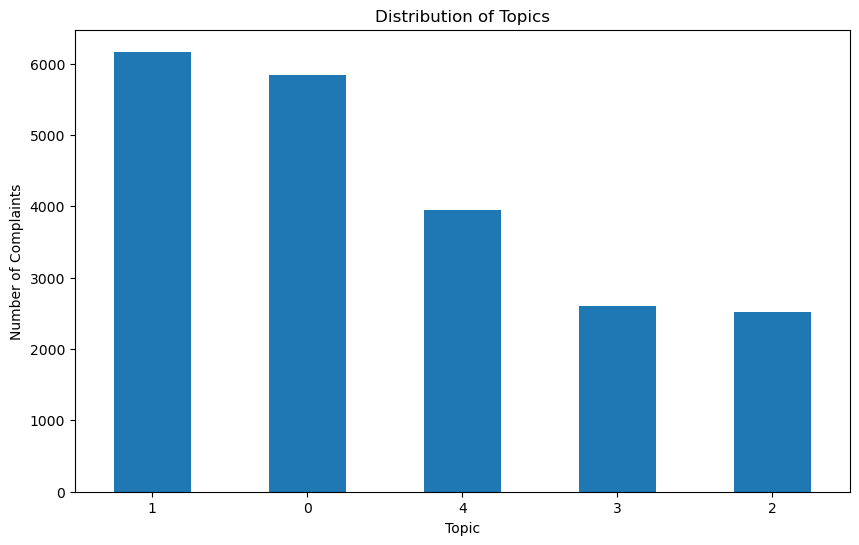

1    6167
0    5834
4    3949
3    2603
2    2519
Name: Topic, dtype: int64


In [49]:
# Counting the number of instances for each topic
topic_counts = df_clean['Topic'].value_counts()

# Plotting the distribution
plt.figure(figsize=(10, 6))
topic_counts.plot(kind='bar')
plt.title('Distribution of Topics')
plt.xlabel('Topic')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=0)
plt.show()

# Printing the exact counts
print(topic_counts)

In [50]:
# using SMOTE to balance the training data

smote = SMOTE(random_state=40)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

# Initializing and training the Logistic Regression model

logreg = LogisticRegression(max_iter=1000, random_state=40)
logreg.fit(X_train_smote, y_train_smote)

# Making predictions

y_pred_logreg = logreg.predict(X_test_tfidf)

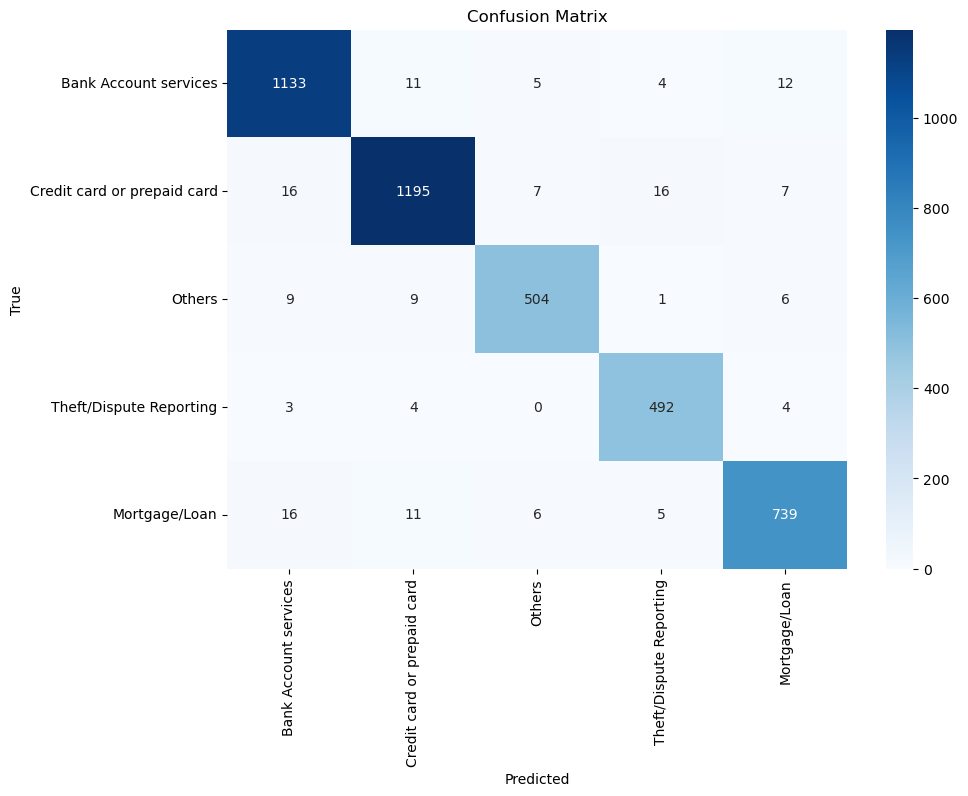

In [51]:
# function for plotting confusion matrix

def plot_confusion_matrix(y_test, y_pred, labels):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# extracting Topic_names from dictionary defined earlier

labels = list(Topic_names.values())

# Plotting the confusion matrix for the model

plot_confusion_matrix(y_test, y_pred_logreg, labels)

In [52]:
# function for finding the accuracy and classification report for the model

def evaluate_and_plot(y_test, y_pred, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy ({model_name}): {accuracy:.4f}')
    print(f'Classification Report ({model_name}):')
    print(classification_report(y_test, y_pred, target_names=labels))
      
# evaluating the scores for the logistic model 

evaluate_and_plot(y_test, y_pred_logreg, 'Logistic Regression')

Accuracy (Logistic Regression): 0.9639
Classification Report (Logistic Regression):
                             precision    recall  f1-score   support

      Bank Account services       0.96      0.97      0.97      1165
Credit card or prepaid card       0.97      0.96      0.97      1241
                     Others       0.97      0.95      0.96       529
    Theft/Dispute Reporting       0.95      0.98      0.96       503
              Mortgage/Loan       0.96      0.95      0.96       777

                   accuracy                           0.96      4215
                  macro avg       0.96      0.96      0.96      4215
               weighted avg       0.96      0.96      0.96      4215



#### The accuracy is around 96% suggesting the model is fitting very well. Next other models like decision trees and random forests are used to assess how the accuracy score behaves.

## Decision Tree Model

In [53]:
from sklearn.tree import DecisionTreeClassifier

# Initializing and training the Decision Tree model

dt_model = DecisionTreeClassifier(random_state=40)
dt_model.fit(X_train_smote, y_train_smote)
y_pred_dt = dt_model.predict(X_test_tfidf)

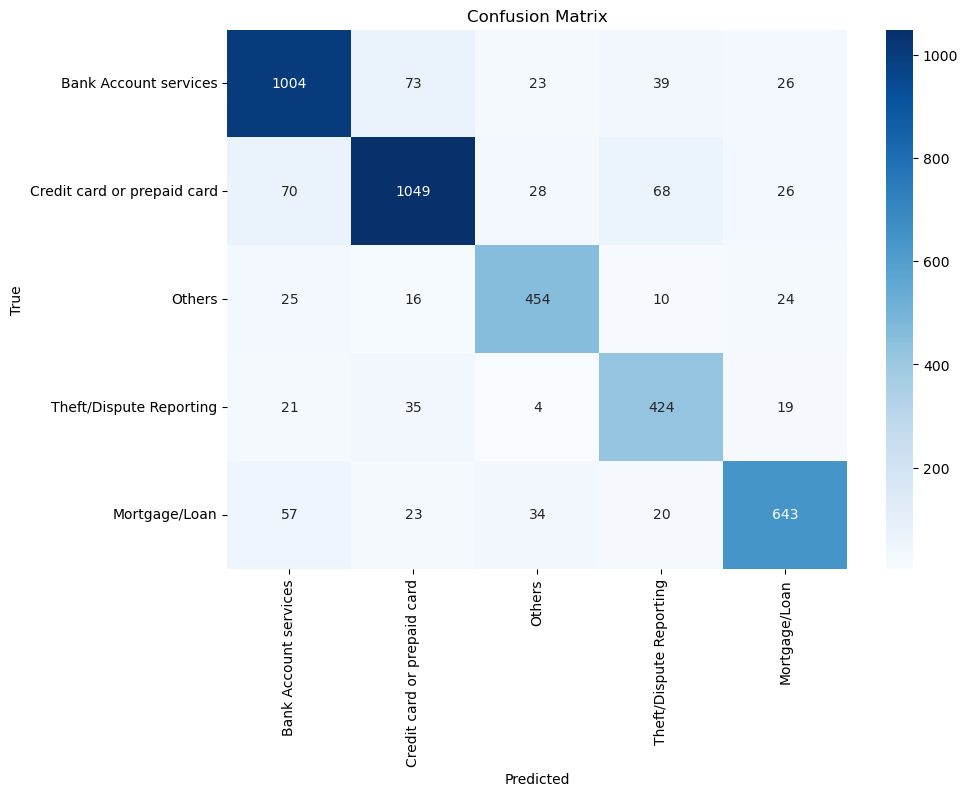

In [54]:
# Plotting the confusion matrix for the decision tree model

plot_confusion_matrix(y_test, y_pred_dt, labels)

In [55]:
# Evaluating the scores for the decision tree model

evaluate_and_plot(y_test, y_pred_dt, 'Decision Tree')

Accuracy (Decision Tree): 0.8479
Classification Report (Decision Tree):
                             precision    recall  f1-score   support

      Bank Account services       0.85      0.86      0.86      1165
Credit card or prepaid card       0.88      0.85      0.86      1241
                     Others       0.84      0.86      0.85       529
    Theft/Dispute Reporting       0.76      0.84      0.80       503
              Mortgage/Loan       0.87      0.83      0.85       777

                   accuracy                           0.85      4215
                  macro avg       0.84      0.85      0.84      4215
               weighted avg       0.85      0.85      0.85      4215



#### It is observed the decision tree model is performing poorly when compared to the logistic model with an accuracy score of just 85%.

## Random Forest Model

In [56]:
from sklearn.ensemble import RandomForestClassifier

# Initializing and training the Random Forest model

rf_model = RandomForestClassifier(random_state=40, n_estimators=100)
rf_model.fit(X_train_smote, y_train_smote)
y_pred_rf = rf_model.predict(X_test_tfidf)

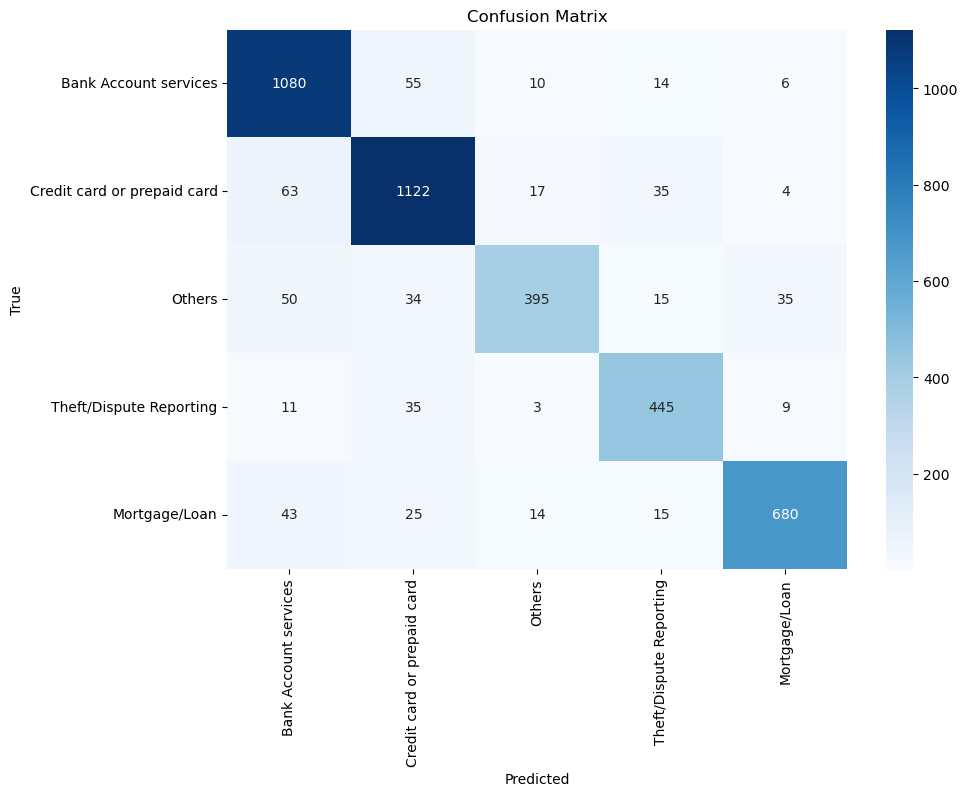

In [57]:
# Plotting the confusion matrix for the random forest model

plot_confusion_matrix(y_test, y_pred_rf, labels)


In [58]:
# evaluating the scores for the random forest model 

evaluate_and_plot(y_test, y_pred_rf, 'Random Forest')

Accuracy (Random Forest): 0.8830
Classification Report (Random Forest):
                             precision    recall  f1-score   support

      Bank Account services       0.87      0.93      0.90      1165
Credit card or prepaid card       0.88      0.90      0.89      1241
                     Others       0.90      0.75      0.82       529
    Theft/Dispute Reporting       0.85      0.88      0.87       503
              Mortgage/Loan       0.93      0.88      0.90       777

                   accuracy                           0.88      4215
                  macro avg       0.88      0.87      0.87      4215
               weighted avg       0.88      0.88      0.88      4215



### Since the accuracy is around 89%, It is observed that a simple logistic regression model seems to perform the best and hence this model is chosen as the optimum model.

### Also it is observed that credit card related issues cause the most complaints, the company should focus on improving their service with regards to card transactions.
